In [1]:
#jupyter notebook setup
from IPython.display import display
#supress warnings
import warnings
warnings.filterwarnings('ignore')

# NOTEBOOK FOR BIKE SHARING CASE STUDY

The notebook will build a linear regression model for bike sharing case study for predicting each of dependent variable - casual users, registered users and all users

>>### DATA LOADING

In [2]:
import numpy as np
import pandas as pd
from  matplotlib import pyplot as plt, patches as mpatches
import seaborn as sns
import sklearn as skl
from sklearn import model_selection as skl_ms, preprocessing as skl_pre, feature_selection as skl_fs, linear_model as skl_lm, metrics as skl_met
import statsmodels.api as sm_api
from statsmodels.stats import outliers_influence as sm_oi

#read data
dataset=pd.read_csv('day.csv')

#removing instant,dtedate column as it is redundant
dataset.drop(['instant','dteday'],axis=1,inplace=True)

>>### UNDERSTANDING DATA

1. Continous Variables

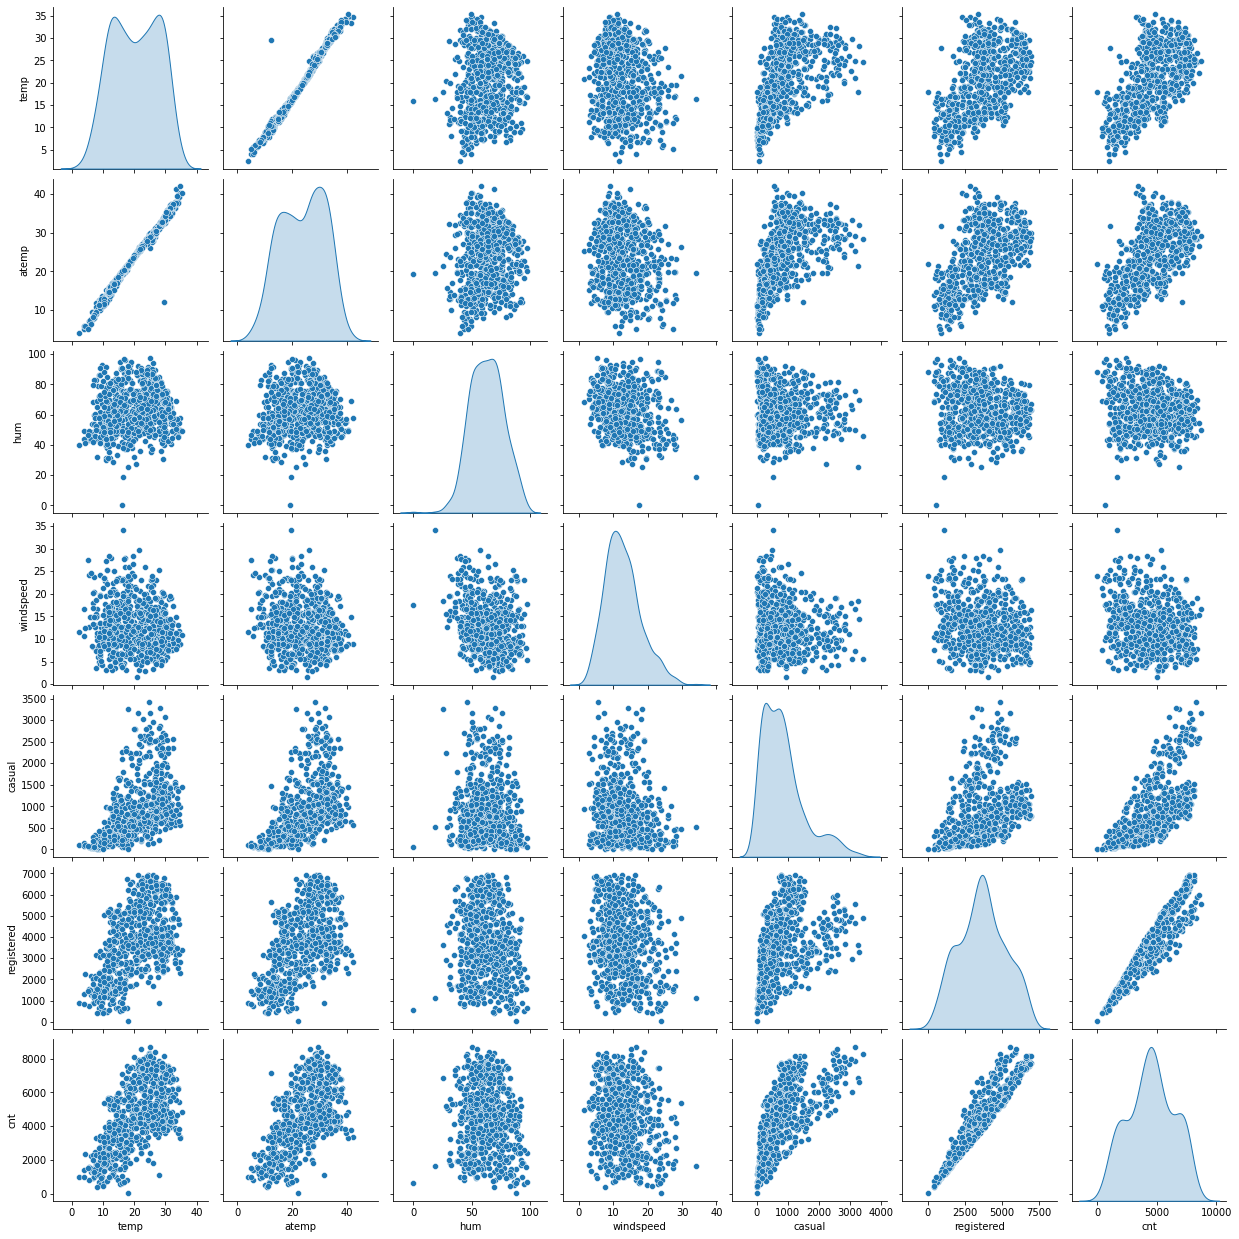

In [3]:
sns.pairplot(dataset,vars=[ 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt'],diag_kind='kde')
plt.show()

2. Categorical Variables

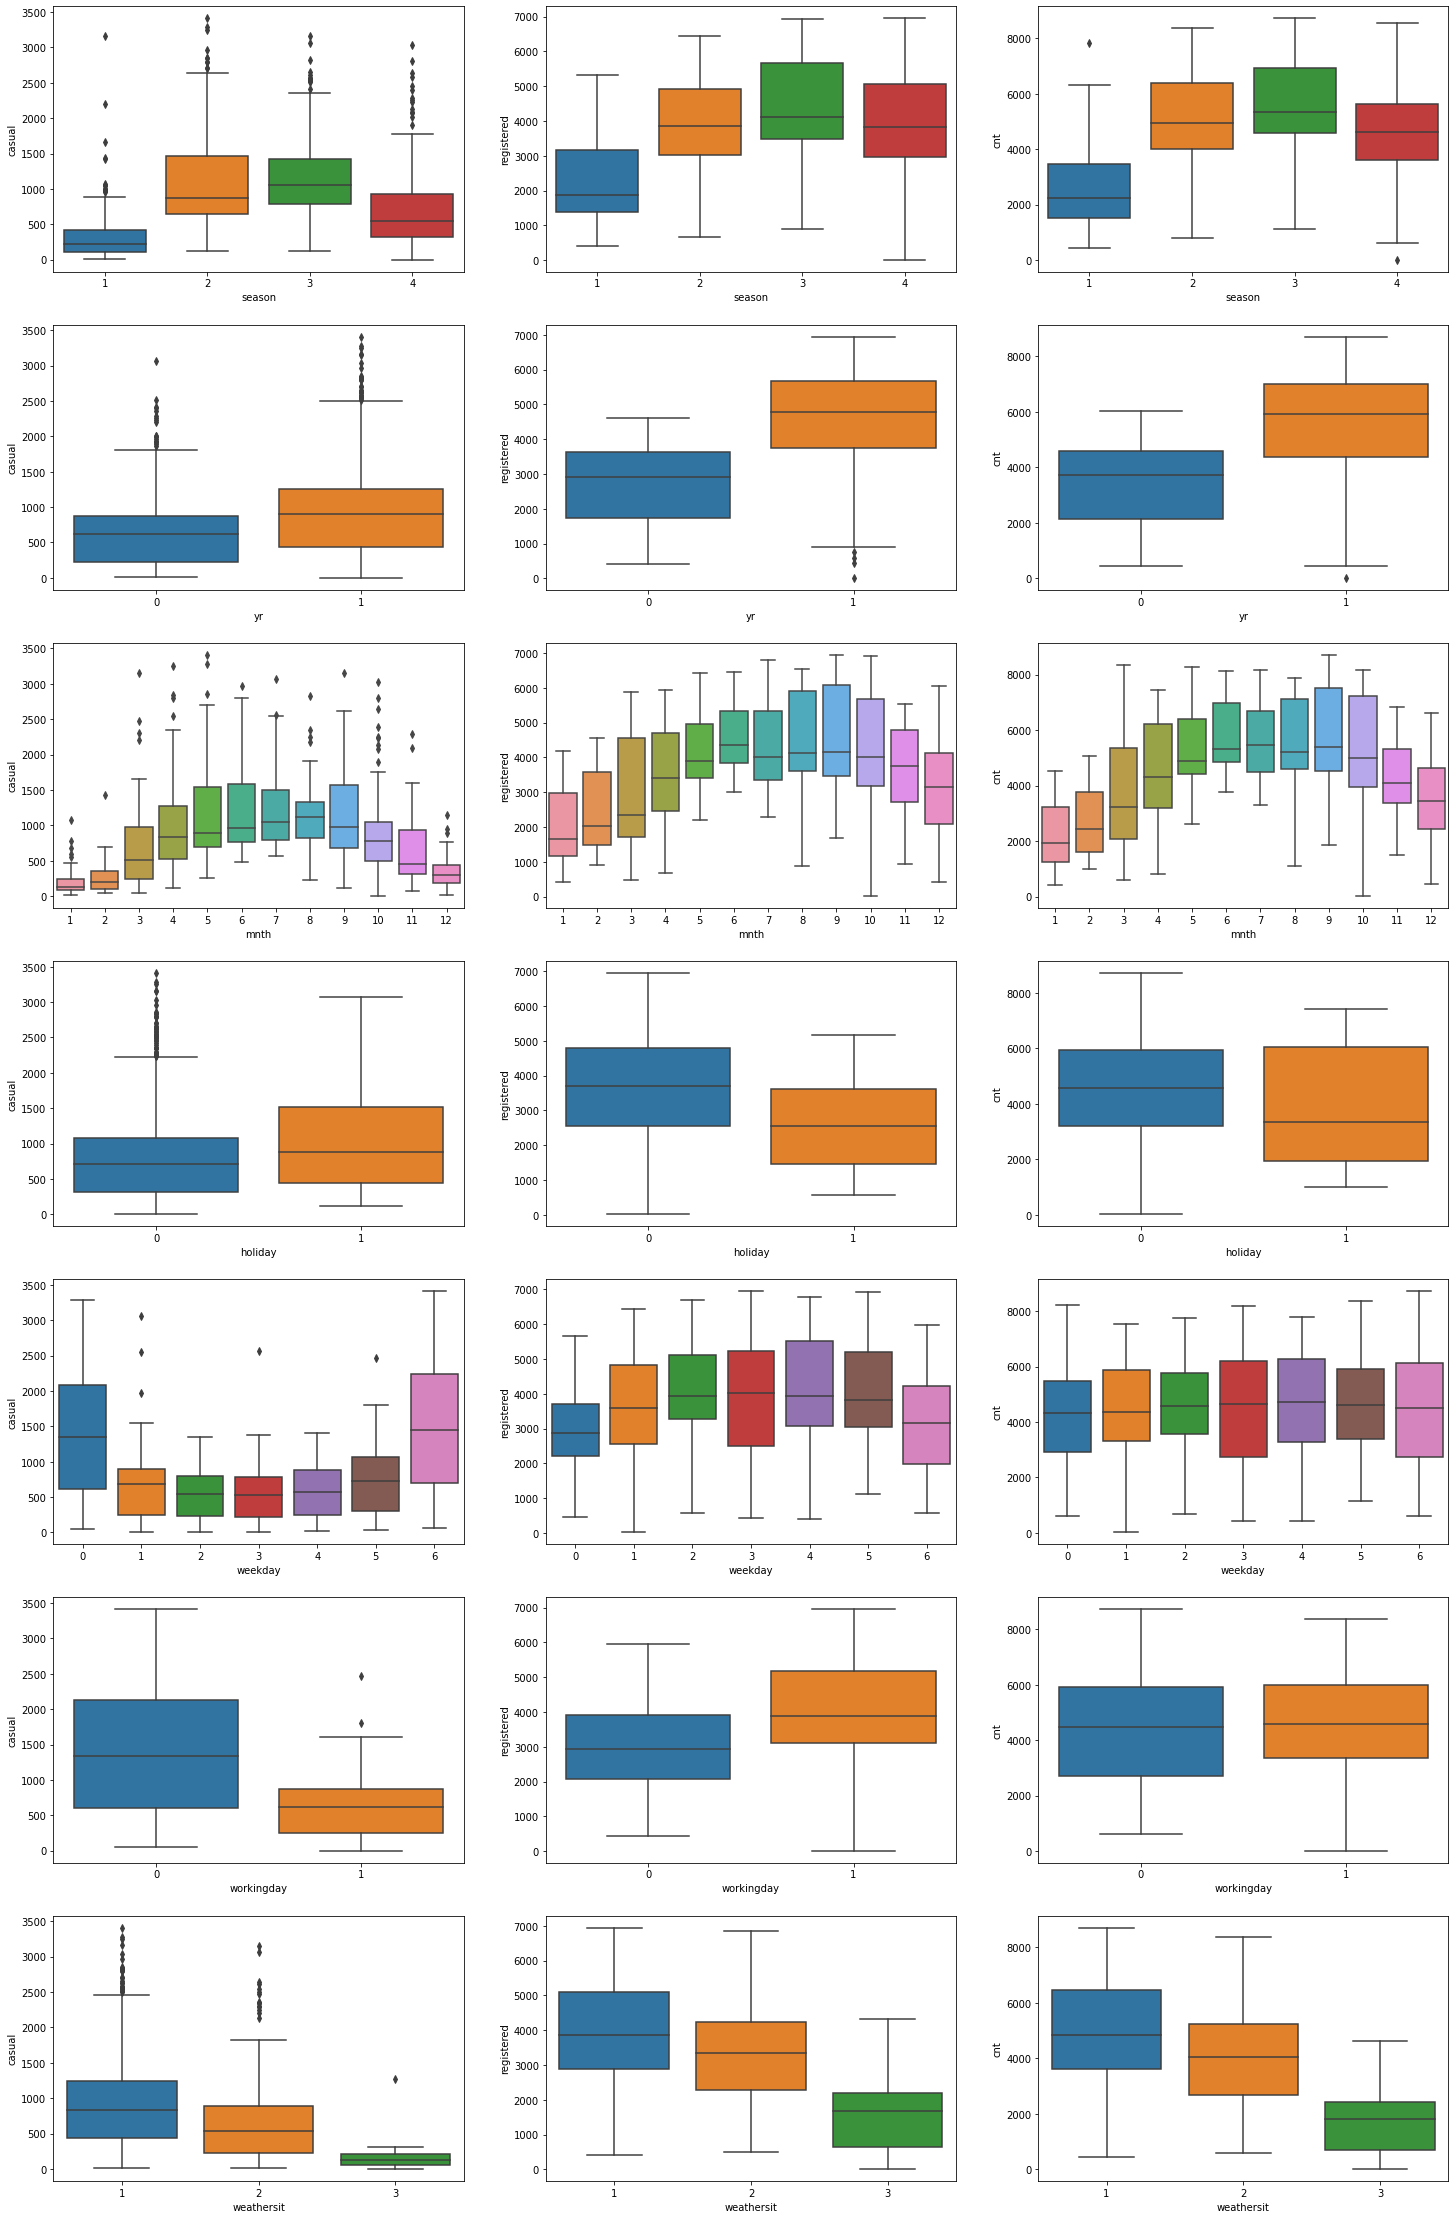

In [4]:
#plot box plots for categorical variabels - season  yr  mnth  holiday  weekday  workingday  weathersit

categorical_var_list=['season',  'yr',  'mnth',  'holiday',  'weekday',  'workingday',  'weathersit']
plot_cordinate = 0

plt.figure(figsize= (25,40))

for i in categorical_var_list:
    plt.subplot(7,3,plot_cordinate+1)
    sns.boxplot(x=i,y='casual',data=dataset)
    plt.subplot(7,3,plot_cordinate+2)
    sns.boxplot(x=i,y='registered',data=dataset)
    plt.subplot(7,3,plot_cordinate+3)
    sns.boxplot(x=i,y='cnt',data=dataset)
    plot_cordinate+=3

plt.show()

3. Correlation

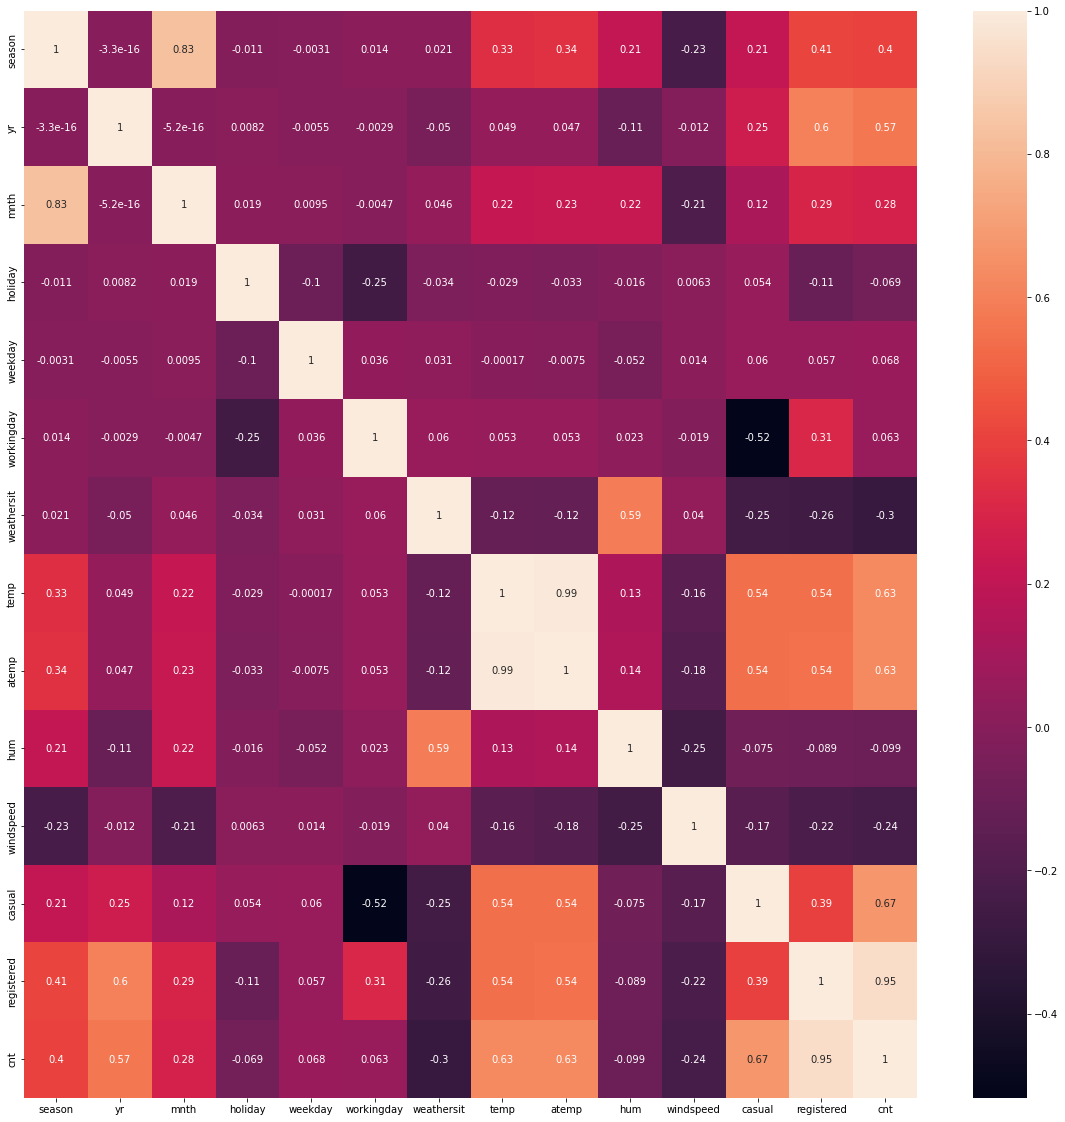

In [5]:
data_correlation=dataset.corr()
plt.figure(figsize=(20,20))
sns.heatmap(data_correlation,annot=True)
plt.show()

>>### DATA PREPARATION FOR MODELLING

In [6]:
#dropping year as it does not makes sense from predictive business analytics as future years cannot be represented in model
dataset=dataset.drop('yr',axis=1)

#Create Dummy variables for multilevel categorical data
dataset_dvars=pd.get_dummies(dataset,drop_first=True,columns=['season','mnth','weekday','weathersit'],prefix=['season','month','weekday','weathersit'])

#Creating seperate dataset for each depenedent varibale - causal, registered, cnt
dataset_dependent_vars=dataset_dvars[['casual','registered','cnt']]
dataset_dvars.drop(['casual','registered','cnt'],axis=1,inplace=True)
dataset_casual=pd.concat([dataset_dependent_vars[['casual']],dataset_dvars],axis=1)
dataset_registered=pd.concat([dataset_dependent_vars[['registered']],dataset_dvars],axis=1)
dataset_cnt=pd.concat([dataset_dependent_vars[['cnt']],dataset_dvars],axis=1)

#train and test data
casual_train_data,casual_test_data = skl_ms.train_test_split(dataset_casual,train_size=0.7,random_state=123)
registered_train_data,registered_test_data = skl_ms.train_test_split(dataset_registered,train_size=0.7,random_state=123)
cnt_train_data,cnt_test_data = skl_ms.train_test_split(dataset_cnt,train_size=0.7,random_state=123)

#scaling numeric variables train data
c_scaler=skl_pre.MinMaxScaler()
r_scaler=skl_pre.MinMaxScaler()
cnt_scaler=skl_pre.MinMaxScaler()
numeric_variables=['temp', 'atemp', 'hum', 'windspeed']
casual_train_data[numeric_variables+['casual']]=c_scaler.fit_transform(casual_train_data[numeric_variables+['casual']])
registered_train_data[numeric_variables+['registered']]=r_scaler.fit_transform(registered_train_data[numeric_variables+['registered']])
cnt_train_data[numeric_variables+['cnt']]=cnt_scaler.fit_transform(cnt_train_data[numeric_variables+['cnt']])

>>### MODEL BUILDING

>>>>1. Dependent Variable 1- Casual

In [7]:
#Seperate dependent and independent variables
c_d_y = d_y = casual_train_data['casual']
d_X = casual_train_data.drop('casual',axis=1)

#create linear model and use RFE for feature selection
d_lm = skl_lm.LinearRegression().fit(d_X,d_y)
d_rfe = skl_fs.RFE(d_lm,n_features_to_select=15).fit(d_X,d_y)

# filter features found irrelevant by RFE
d_X1=d_X[d_X.columns[d_rfe.support_]]

In [8]:
#creat a OLS model using statsmodel
d_X1=sm_api.add_constant(d_X1)
d_lm=sm_api.OLS(d_y,d_X1).fit()
display(d_lm.summary())

#create a p-score and VIF table
model_summary=pd.read_html(d_lm.summary().tables[1].as_html(),header=0)[0]
pvalue_df=model_summary[['Unnamed: 0','P>|t|']].rename({'Unnamed: 0':'feature','P>|t|':'pvalue'},axis=1)
vif_df=pd.DataFrame([d_X1.columns.to_list(),
    [round(sm_oi.variance_inflation_factor(d_X1.values,i),2) 
    for i in range(d_X1.shape[1])]]).T.rename({0:'feature',1:'vif'},axis=1)
pd.merge(pvalue_df,vif_df,on='feature').sort_values(by=['pvalue','vif'],ascending=False)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 casual   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     83.53
Date:                Wed, 15 Dec 2021   Prob (F-statistic):          1.90e-120
Time:                        23:24:19   Log-Likelihood:                 392.03
No. Observations:                 510   AIC:                            -754.1
Df Residuals:                     495   BIC:                            -690.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.3202      0.033      9.722      0.000       0.255       0.385
holiday         -0.0366      0.025     -1.489      0.137      -0.085       0.012
workingday      -0.2008      0.010    -21.058      0.000      -0.220      -0.182
temp             0.5050      0.024     20.964      0.000       0.458       0.552
hum             -0.2324      0.039     -5.930      0.000      -0.309      -0.155
windspeed       -0.1922      0.034     -5.727      0.000      -0.258      -0.126
season_2         0.0954      0.012      7.688      0.000       0.071       0.120
month_3          0.0583      0.018      3.184      0.002       0.022       0.094
month_9          0.0600      0.021      2.866      0.004       0.019       0.101
month_10         0.0948      0.019      4.929      0.000       0.057       0.133
weekday_1       -0.0467      0.012     -3.837      0.000      -0.071      -0.023
weekday_2       -0.0534      0.013     -4.081      0.000      -0.079      -0.028
weekday_3       -0.0638      0.013     -4.829      0.000      -0.090      -0.038
weekday_4       -0.0635      0.013     -4.817      0.000      -0.089      -0.038
weekday_5       -0.0100      0.014     -0.742      0.459      -0.037       0.017
weathersit_3    -0.0394      0.031     -1.278      0.202      -0.100       0.021
==============================================================================
Omnibus:                       58.967   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.579
Skew:                           0.723   Prob(JB):                     8.76e-23
Kurtosis:                       4.640   Cond. No.                     5.44e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.37e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

,feature,pvalue,vif
14,weekday_5,0.459,inf
15,weathersit_3,0.202,1.21
1,holiday,0.137,inf
8,month_9,0.004,1.13
7,month_3,0.002,1.06
2,workingday,0.000,inf
10,weekday_1,0.000,inf
11,weekday_2,0.000,inf
12,weekday_3,0.000,inf
13,weekday_4,0.000,inf


In [9]:
#Rebuild model after dropping insignificant features obtained after analysis of VIF and Pvalue
d_X2=d_X1.drop(['weekday_5','weekday_1','weekday_2','weekday_3','weekday_4','holiday'],axis=1)
d_lm=sm_api.OLS(d_y,d_X2).fit()
d_c_train_final=d_X2
c_d_lm=d_lm
display(d_lm.summary())


#create final p-score and VIF table
model_summary=pd.read_html(d_lm.summary().tables[1].as_html(),header=0)[0]
pvalue_df=model_summary[['Unnamed: 0','P>|t|']].rename({'Unnamed: 0':'feature','P>|t|':'pvalue'},axis=1)
vif_df=pd.DataFrame([d_X2.columns.to_list(),
    [round(sm_oi.variance_inflation_factor(d_X2.values,i),2) 
    for i in range(d_X2.shape[1])]]).T.rename({0:'feature',1:'vif'},axis=1)
pd.merge(pvalue_df,vif_df,on='feature').sort_values(by=['pvalue','vif'],ascending=False)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 casual   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     124.4
Date:                Wed, 15 Dec 2021   Prob (F-statistic):          1.57e-121
Time:                        23:24:19   Log-Likelihood:                 382.46
No. Observations:                 510   AIC:                            -744.9
Df Residuals:                     500   BIC:                            -702.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.3148      0.033      9.504      0.000       0.250       0.380
workingday      -0.2394      0.011    -21.662      0.000      -0.261      -0.218
temp             0.4980      0.024     20.510      0.000       0.450       0.546
hum             -0.2343      0.040     -5.920      0.000      -0.312      -0.157
windspeed       -0.1923      0.034     -5.668      0.000      -0.259      -0.126
season_2         0.0969      0.013      7.710      0.000       0.072       0.122
month_3          0.0611      0.019      3.297      0.001       0.025       0.097
month_9          0.0618      0.021      2.925      0.004       0.020       0.103
month_10         0.0954      0.019      4.903      0.000       0.057       0.134
weathersit_3    -0.0455      0.031     -1.463      0.144      -0.107       0.016
==============================================================================
Omnibus:                       61.267   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.303
Skew:                           0.763   Prob(JB):                     1.01e-22
Kurtosis:                       4.561   Cond. No.                         16.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,feature,pvalue,vif
9,weathersit_3,0.144,1.19
7,month_9,0.004,1.12
6,month_3,0.001,1.06
0,const,0.000,41.99
3,hum,0.000,1.29
4,windspeed,0.000,1.2
2,temp,0.000,1.16
5,season_2,0.000,1.15
8,month_10,0.000,1.09
1,workingday,0.000,1.01


>>>>2. Dependent Variable 2 - Registered

In [10]:
#Seperate dependent and independent variables
r_d_y = d_y = registered_train_data['registered']
d_X = registered_train_data.drop('registered',axis=1)

#create linear model and use RFE for feature selection
d_lm = skl_lm.LinearRegression().fit(d_X,d_y)
d_rfe = skl_fs.RFE(d_lm,n_features_to_select=15).fit(d_X,d_y)

# filter features found irrelevant by RFE
d_X1=d_X[d_X.columns[d_rfe.support_]]

In [11]:
#creat a OLS model using statsmodel
d_X1=sm_api.add_constant(d_X1)
d_lm=sm_api.OLS(d_y,d_X1).fit()
display(d_lm.summary())

#create a p-score and VIF table
model_summary=pd.read_html(d_lm.summary().tables[1].as_html(),header=0)[0]
pvalue_df=model_summary[['Unnamed: 0','P>|t|']].rename({'Unnamed: 0':'feature','P>|t|':'pvalue'},axis=1)
vif_df=pd.DataFrame([d_X1.columns.to_list(),
    [round(sm_oi.variance_inflation_factor(d_X1.values,i),2) 
    for i in range(d_X1.shape[1])]]).T.rename({0:'feature',1:'vif'},axis=1)
pd.merge(pvalue_df,vif_df,on='feature').sort_values(by=['pvalue','vif'],ascending=False)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             registered   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     51.45
Date:                Wed, 15 Dec 2021   Prob (F-statistic):           4.40e-87
Time:                        23:24:19   Log-Likelihood:                 251.68
No. Observations:                 510   AIC:                            -473.4
Df Residuals:                     495   BIC:                            -409.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.3198      0.045      7.036      0.000       0.230       0.409
holiday         -0.0356      0.034     -1.057      0.291      -0.102       0.031
workingday       0.1342      0.016      8.461      0.000       0.103       0.165
temp             0.5775      0.032     18.066      0.000       0.515       0.640
hum             -0.3357      0.052     -6.515      0.000      -0.437      -0.234
windspeed       -0.1890      0.044     -4.248      0.000      -0.276      -0.102
season_2         0.0697      0.017      4.186      0.000       0.037       0.102
season_4         0.1830      0.017     10.529      0.000       0.149       0.217
month_9          0.1226      0.027      4.493      0.000       0.069       0.176
weekday_1        0.0072      0.016      0.439      0.661      -0.025       0.040
weekday_2        0.0329      0.018      1.861      0.063      -0.002       0.068
weekday_3        0.0186      0.018      1.042      0.298      -0.016       0.054
weekday_4        0.0388      0.018      2.185      0.029       0.004       0.074
weekday_5        0.0011      0.018      0.060      0.952      -0.035       0.037
weekday_6        0.0486      0.025      1.918      0.056      -0.001       0.098
weathersit_3    -0.2248      0.041     -5.516      0.000      -0.305      -0.145
==============================================================================
Omnibus:                       58.079   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.625
Skew:                          -0.035   Prob(JB):                     0.000245
Kurtosis:                       2.118   Cond. No.                     5.91e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.77e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

,feature,pvalue,vif
13,weekday_5,0.952,inf
9,weekday_1,0.661,inf
11,weekday_3,0.298,inf
1,holiday,0.291,inf
10,weekday_2,0.063,inf
14,weekday_6,0.056,1.85
12,weekday_4,0.029,inf
2,workingday,0.000,inf
0,const,0.000,46.85
4,hum,0.000,1.29


In [12]:
#Rebuild model after dropping insignificant features obtained after analysis of VIF and Pvalue
d_X2=d_X1.drop(['weekday_5','weekday_1','weekday_3','holiday','weekday_2','weekday_4'],axis=1)
d_lm=sm_api.OLS(d_y,d_X2).fit()
d_r_train_final=d_X2
r_d_lm=d_lm
display(d_lm.summary())

#create final p-score and VIF table
model_summary=pd.read_html(d_lm.summary().tables[1].as_html(),header=0)[0]
pvalue_df=model_summary[['Unnamed: 0','P>|t|']].rename({'Unnamed: 0':'feature','P>|t|':'pvalue'},axis=1)
vif_df=pd.DataFrame([d_X2.columns.to_list(),
    [round(sm_oi.variance_inflation_factor(d_X2.values,i),2) 
    for i in range(d_X2.shape[1])]]).T.rename({0:'feature',1:'vif'},axis=1)
pd.merge(pvalue_df,vif_df,on='feature').sort_values(by=['pvalue','vif'],ascending=False)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             registered   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     79.83
Date:                Wed, 15 Dec 2021   Prob (F-statistic):           6.73e-91
Time:                        23:24:19   Log-Likelihood:                 249.80
No. Observations:                 510   AIC:                            -479.6
Df Residuals:                     500   BIC:                            -437.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.3149      0.044      7.076      0.000       0.227       0.402
workingday       0.1603      0.018      8.804      0.000       0.124       0.196
temp             0.5820      0.032     18.322      0.000       0.520       0.644
hum             -0.3387      0.051     -6.609      0.000      -0.439      -0.238
windspeed       -0.1918      0.044     -4.328      0.000      -0.279      -0.105
season_2         0.0690      0.017      4.157      0.000       0.036       0.102
season_4         0.1824      0.017     10.521      0.000       0.148       0.217
month_9          0.1222      0.027      4.508      0.000       0.069       0.175
weekday_6        0.0543      0.024      2.287      0.023       0.008       0.101
weathersit_3    -0.2211      0.040     -5.461      0.000      -0.301      -0.142
==============================================================================
Omnibus:                       55.965   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.328
Skew:                          -0.035   Prob(JB):                     0.000285
Kurtosis:                       2.126   Cond. No.                         16.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,feature,pvalue,vif
8,weekday_6,0.023,1.63
0,const,0.000,45.04
1,workingday,0.000,1.63
3,hum,0.000,1.28
4,windspeed,0.000,1.22
6,season_4,0.000,1.22
5,season_2,0.000,1.2
9,weathersit_3,0.000,1.2
2,temp,0.000,1.18
7,month_9,0.000,1.1


>>>>3. Dependent Variable 3 - cnt

In [13]:
#Seperate dependent and independent variables
cnt_d_y = d_y = cnt_train_data['cnt']
d_X = cnt_train_data.drop('cnt',axis=1)

#create linear model and use RFE for feature selection
d_lm = skl_lm.LinearRegression().fit(d_X,d_y)
d_rfe = skl_fs.RFE(d_lm,n_features_to_select=15).fit(d_X,d_y)

# filter features found irrelevant by RFE
d_X1=d_X[d_X.columns[d_rfe.support_]]

In [14]:
#creat a OLS model using statsmodel
d_X1=sm_api.add_constant(d_X1)
d_lm=sm_api.OLS(d_y,d_X1).fit()
display(d_lm.summary())

#create a p-score and VIF table
model_summary=pd.read_html(d_lm.summary().tables[1].as_html(),header=0)[0]
pvalue_df=model_summary[['Unnamed: 0','P>|t|']].rename({'Unnamed: 0':'feature','P>|t|':'pvalue'},axis=1)
vif_df=pd.DataFrame([d_X1.columns.to_list(),
    [round(sm_oi.variance_inflation_factor(d_X1.values,i),2) 
    for i in range(d_X1.shape[1])]]).T.rename({0:'feature',1:'vif'},axis=1)
pd.merge(pvalue_df,vif_df,on='feature').sort_values(by=['pvalue','vif'],ascending=False)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     57.57
Date:                Wed, 15 Dec 2021   Prob (F-statistic):           2.70e-94
Time:                        23:24:19   Log-Likelihood:                 261.71
No. Observations:                 510   AIC:                            -493.4
Df Residuals:                     495   BIC:                            -429.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.3765      0.045      8.448      0.000       0.289       0.464
holiday         -0.0401      0.033     -1.215      0.225      -0.105       0.025
workingday       0.0352      0.016      2.265      0.024       0.005       0.066
temp             0.6759      0.031     21.565      0.000       0.614       0.738
hum             -0.3672      0.051     -7.270      0.000      -0.466      -0.268
windspeed       -0.2247      0.044     -5.150      0.000      -0.310      -0.139
season_2         0.0961      0.016      5.885      0.000       0.064       0.128
season_4         0.1686      0.017      9.896      0.000       0.135       0.202
month_9          0.1170      0.027      4.375      0.000       0.064       0.170
weekday_1       -0.0089      0.016     -0.549      0.583      -0.041       0.023
weekday_2        0.0063      0.017      0.364      0.716      -0.028       0.040
weekday_3       -0.0090      0.017     -0.515      0.607      -0.043       0.025
weekday_4        0.0081      0.017      0.463      0.644      -0.026       0.042
weekday_5       -0.0014      0.018     -0.079      0.937      -0.036       0.034
weekday_6        0.0536      0.025      2.154      0.032       0.005       0.102
weathersit_3    -0.1989      0.040     -4.977      0.000      -0.277      -0.120
==============================================================================
Omnibus:                       21.894   Durbin-Watson:                   1.850
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.654
Skew:                          -0.001   Prob(JB):                      0.00801
Kurtosis:                       2.326   Cond. No.                     5.91e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.77e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

,feature,pvalue,vif
13,weekday_5,0.937,inf
10,weekday_2,0.716,inf
12,weekday_4,0.644,inf
11,weekday_3,0.607,inf
9,weekday_1,0.583,inf
1,holiday,0.225,inf
14,weekday_6,0.032,1.85
2,workingday,0.024,inf
0,const,0.000,46.85
4,hum,0.000,1.29


In [15]:
#Rebuild model after dropping insignificant features obtained after analysis of VIF and Pvalue
d_X2=d_X1.drop(['weekday_5','weekday_1','weekday_2','weekday_3','holiday','weekday_4'],axis=1)
d_lm=sm_api.OLS(d_y,d_X2).fit()
d_cnt_train_final=d_X2
cnt_d_lm=d_lm
display(d_lm.summary())

#create final p-score and VIF table
model_summary=pd.read_html(d_lm.summary().tables[1].as_html(),header=0)[0]
pvalue_df=model_summary[['Unnamed: 0','P>|t|']].rename({'Unnamed: 0':'feature','P>|t|':'pvalue'},axis=1)
vif_df=pd.DataFrame([d_X2.columns.to_list(),
    [round(sm_oi.variance_inflation_factor(d_X2.values,i),2) 
    for i in range(d_X2.shape[1])]]).T.rename({0:'feature',1:'vif'},axis=1)
pd.merge(pvalue_df,vif_df,on='feature').sort_values(by=['pvalue','vif'],ascending=False)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     89.77
Date:                Wed, 15 Dec 2021   Prob (F-statistic):           1.62e-98
Time:                        23:24:20   Log-Likelihood:                 260.51
No. Observations:                 510   AIC:                            -501.0
Df Residuals:                     500   BIC:                            -458.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.3682      0.044      8.451      0.000       0.283       0.454
workingday       0.0450      0.018      2.522      0.012       0.010       0.080
temp             0.6770      0.031     21.767      0.000       0.616       0.738
hum             -0.3705      0.050     -7.383      0.000      -0.469      -0.272
windspeed       -0.2270      0.043     -5.231      0.000      -0.312      -0.142
season_2         0.0961      0.016      5.910      0.000       0.064       0.128
season_4         0.1686      0.017      9.929      0.000       0.135       0.202
month_9          0.1174      0.027      4.423      0.000       0.065       0.170
weekday_6        0.0641      0.023      2.754      0.006       0.018       0.110
weathersit_3    -0.1994      0.040     -5.029      0.000      -0.277      -0.121
==============================================================================
Omnibus:                       21.751   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.616
Skew:                           0.004   Prob(JB):                      0.00816
Kurtosis:                       2.327   Cond. No.                         16.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,feature,pvalue,vif
1,workingday,0.012,1.63
8,weekday_6,0.006,1.63
0,const,0.000,45.04
3,hum,0.000,1.28
4,windspeed,0.000,1.22
6,season_4,0.000,1.22
5,season_2,0.000,1.2
9,weathersit_3,0.000,1.2
2,temp,0.000,1.18
7,month_9,0.000,1.1


>>### RESIDUAL ANALYSIS

Normal distribution of error terms


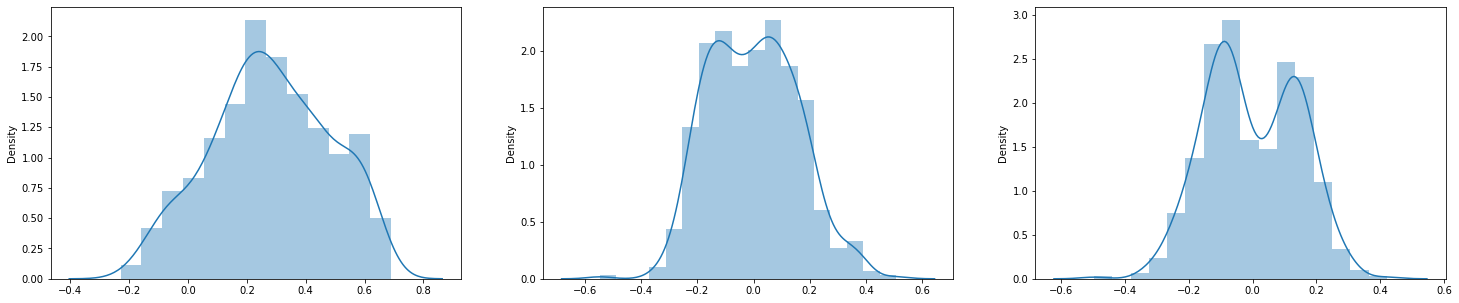

Homoscedasticity


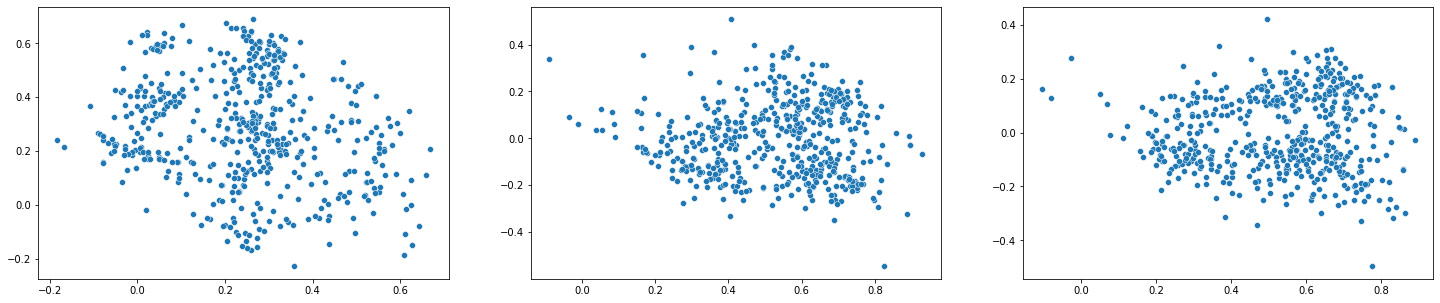

In [16]:
predicted_vars=[c_d_lm.predict(d_c_train_final),r_d_lm.predict(d_r_train_final),cnt_d_lm.predict(d_cnt_train_final)]
actual_vars = [c_d_y,r_d_y,cnt_d_y]
#plot for checking normal distribution of residuals
plt.figure(figsize=(25,5))
print('Normal distribution of error terms')
for i in range(3):
    plt.subplot(1,3,i+1)
    sns.distplot(d_y-predicted_vars[i])
plt.show()

#plot for checking homoscedascticty
print('Homoscedasticity')
plt.figure(figsize=(25,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    sns.scatterplot(y=d_y-predicted_vars[i],x=predicted_vars[i])
plt.show()

>>### PREDICTION USING MODEL

In [17]:
#scaling test data
numeric_variables=['temp', 'atemp', 'hum', 'windspeed']
casual_test_data[numeric_variables+['casual']]=c_scaler.transform(casual_test_data[numeric_variables+['casual']])
registered_test_data[numeric_variables+['registered']]=r_scaler.transform(registered_test_data[numeric_variables+['registered']])
cnt_test_data[numeric_variables+['cnt']]=cnt_scaler.transform(cnt_test_data[numeric_variables+['cnt']])

#filtering final selected features on test data
c_test_y = casual_test_data['casual']
c_test_X = casual_test_data.drop('casual',axis=1)
c_test_cols=d_c_train_final.columns.tolist()
c_test_cols.remove('const')
c_test_X=c_test_X[c_test_cols]

r_test_y = registered_test_data['registered']
r_test_X = registered_test_data.drop('registered',axis=1)
r_test_cols=d_r_train_final.columns.tolist()
r_test_cols.remove('const')
r_test_X=r_test_X[r_test_cols]

cnt_test_y = cnt_test_data['cnt']
cnt_test_X = cnt_test_data.drop('cnt',axis=1)
cnt_test_cols=d_cnt_train_final.columns.tolist()
cnt_test_cols.remove('const')
cnt_test_X=cnt_test_X[cnt_test_cols]

predicted_data = []
for td,ml in zip([c_test_X,r_test_X,cnt_test_X],[c_d_lm,r_d_lm,cnt_d_lm]):
    td_new=sm_api.add_constant(td)
    predicted_data.append(ml.predict(td_new))


>>### MODEL EVALUATION

In [18]:
#calculate r2 scores and rmse on test data
eval_df = pd.DataFrame()
eval_df['dependent_var'] = ['casual','registered','cnt']
eval_df['r2_score']=[skl_met.r2_score(y_true=tr,y_pred=pr) for tr,pr in zip([c_test_y,r_test_y,cnt_test_y],predicted_data)]
eval_df['rmse']=[skl_met.mean_squared_error(y_true=tr,y_pred=pr) for tr,pr in zip([c_test_y,r_test_y,cnt_test_y],predicted_data)]
eval_df

,dependent_var,r2_score,rmse
0,casual,0.627688,0.013499
1,registered,0.397179,0.026441
2,cnt,0.416940,0.024921


In [19]:
#Model equations

for mdl,dep_var in zip([c_d_lm,r_d_lm,cnt_d_lm],['casual','registered','cnt']):
    x=pd.read_html(mdl.summary().tables[1].as_html(),header=0)[0][['coef','Unnamed: 0']]
    print(dep_var+' = ',end=' ')
    print(' + '.join(list('('+x['coef'].astype(str)+')'+'*'+x['Unnamed: 0'])))
    print('--------')
    

casual =  (0.3148)*const + (-0.2394)*workingday + (0.498)*temp + (-0.2343)*hum + (-0.1923)*windspeed + (0.0969)*season_2 + (0.0611)*month_3 + (0.0618)*month_9 + (0.0954)*month_10 + (-0.0455)*weathersit_3
--------
registered =  (0.3149)*const + (0.1603)*workingday + (0.582)*temp + (-0.3387)*hum + (-0.1918)*windspeed + (0.069)*season_2 + (0.1824)*season_4 + (0.1222)*month_9 + (0.0543)*weekday_6 + (-0.2211)*weathersit_3
--------
cnt =  (0.3682)*const + (0.045)*workingday + (0.677)*temp + (-0.3705)*hum + (-0.227)*windspeed + (0.0961)*season_2 + (0.1686)*season_4 + (0.1174)*month_9 + (0.0641)*weekday_6 + (-0.1994)*weathersit_3
--------
